In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications.vgg16 import preprocess_input as pi
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img
from skimage.measure import label, regionprops
# !pip install git+https://github.com/tensorflow/examples.git

#for cropping segment
from skimage.measure import label, regionprops
from skimage.transform import rotate, resize
from scipy.ndimage import binary_fill_holes

!clear

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install segmentation_models
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb4'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, input_shape=(384,384,3),encoder_weights='imagenet',activation='sigmoid')
model.load_weights('/kaggle/input/unetopticmodels/UNetOpticModels/U-Net384/U-Net/U-Net384.h5')
!clear

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap='gray')
    plt.axis('off')
  plt.show()

In [4]:
import glob
import cv2
import os
images_t = glob.glob("/kaggle/input/trainzip/train/*.jpeg")
labels_t=pd.read_csv('/kaggle/input/trainlabelcsv/trainLabels.csv')

In [5]:
img_h=384
img_w=384

train_img=np.zeros((len(images_t),img_h,img_w,3),dtype='float32')
train_label=np.zeros((len(images_t)))

In [6]:
train_img.shape

(1427, 384, 384, 3)

In [7]:
n=0
for i,id in tqdm(enumerate(images_t),total=len(images_t)):
  name=((id.split('/'))[-1])[:-5]
  # if limit[(labels_t[(labels_t.image==name)])['level'].values[0]]>=220:
  #   continue
  # limit[(labels_t[(labels_t.image==name)])['level'].values[0]]+=1
  img=load_img(id,target_size=(img_h,img_w))
  img=img_to_array(img)
  train_img[n]=img
  train_label[n]=(labels_t[(labels_t.image==name)])['level'].values[0]
  n+=1
  # train_label[i][(labels_t[(labels_t.image==name)])['level'].values[0]]=(labels_t[(labels_t.image==name)])['level'].values[0]

100%|██████████| 1427/1427 [01:50<00:00, 12.87it/s]


In [8]:
# np.save('pred_disc',model.predict(train_img))

In [9]:
train_img[0].shape

(384, 384, 3)

In [10]:
pred_disc=model.predict(train_img)

45/45 [==============================] - 29s 367ms/step


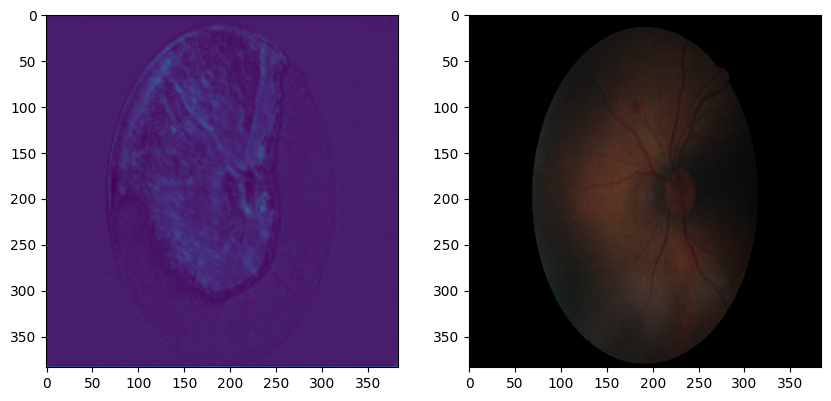

In [11]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
ax[0].imshow(pred_disc[157])
ax[1].imshow(train_img[157]/255.)

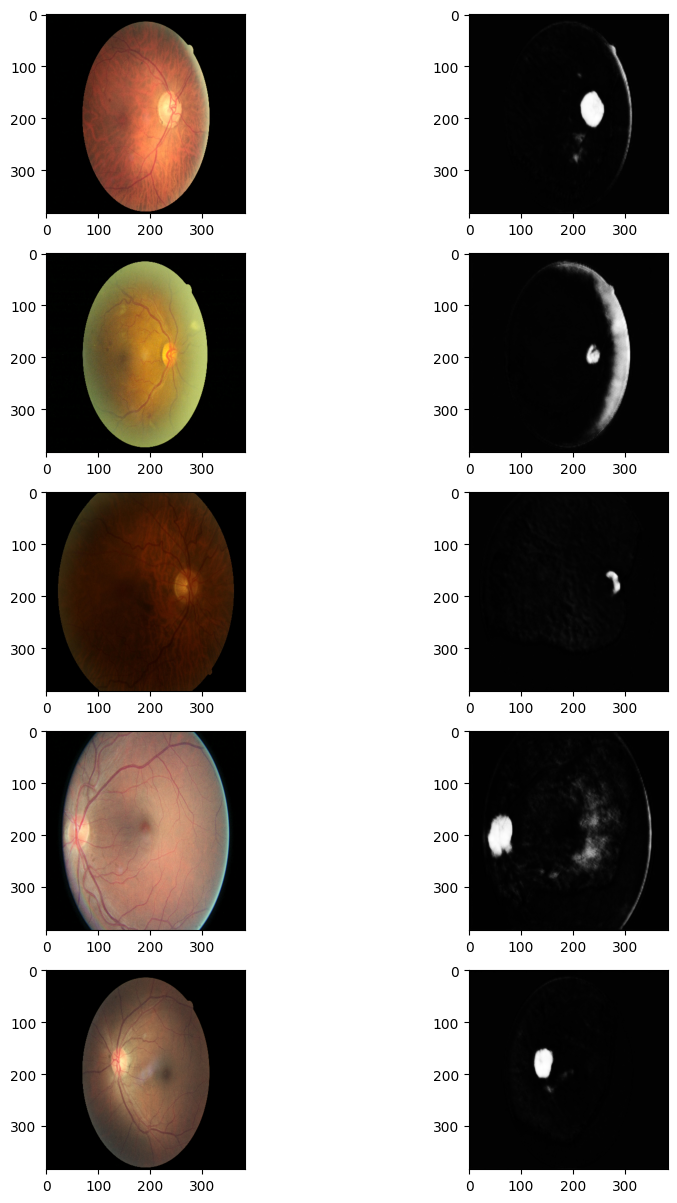

In [13]:
fig, ax=plt.subplots(nrows=5,ncols=2,figsize=(10,15))
k=0
for i in range(5):
#     for j in range(5):
#         ax[i][j].imshow(pred_disc[k])
#         k+=1
#         ax[i][j].axis('off')
      ax[i][0].imshow(train_img[k]/255.)
      ax[i][1].imshow(pred_disc[k],cmap='gray')
      k+=1

########################################################################################################

In [146]:
# save_pred=pred_disc.copy()
# train_save=train_img.copy()

In [14]:
weights_max=np.zeros((pred_disc.shape[0]))
for i in range(pred_disc.shape[0]):
    weights_max[i]=np.max(pred_disc[i])
print(np.min(weights_max))
print(np.max(weights_max))

0.13524861633777618
0.9995260238647461


In [12]:
dataset=np.zeros((train_img.shape[0],256,256,3))
# new_label=np.zeros((train_img.shape[0]))

In [13]:
pred_disc[0].shape

(384, 384, 1)

In [14]:
left_out=[]
for i in tqdm(range(0,train_img.shape[0])):
#     bw=model.predict(train_img[i:i+1],verbose=0)[0].copy()
    bw=pred_disc[i].copy()
    
    #Clearing the noise that the predicted image might have, thus disc should be within 75:309x75:309
    bw[:75,:,:]=0;bw[-75:,:,:]=0;bw[:,:75,:]=0;bw[:,-75:,:]=0;   
    zeros=np.where(bw<0.15)
    ones=np.where(bw>=0.15)
    
    if (len(ones[0])+len(ones[1])+len(ones[2]))<25:
        left_out.append(i)
        continue
    bw[zeros]=0
    bw[ones]=1
    
    #Tweaking image by blacking out 25 pixel from all sides
    
    
    bw=bw.astype('uint8')
    regions = regionprops(bw)
#     print(i,regions[0].centroid)
#     bw[int(regions[0].centroid[0]),int(regions[0].centroid[1])]=0
    C_x = int(regions[0].centroid[0] * train_img[0].shape[0] / img_h)
    C_y = int(regions[0].centroid[1] * train_img[0].shape[1] / img_h)
    
    x_dec=0;x_inc=0;y_dec=0;y_inc=0
    if C_x<train_img[i].shape[0]//2:
        x_dec=128
        x_inc=128
    else:
        x_dec=128
        x_inc=128
    if C_y<train_img[i].shape[1]//2:
        y_dec=100
        y_inc=156
    else:
        y_dec=156
        y_inc=100
        
    if abs(C_x-train_img[i].shape[0]//2)<30:      #Tweaking the result since some images crop too high up
        C_x=train_img[i].shape[0]//2
    if abs(C_y-train_img[i].shape[0]//2)<30:      #Tweaking the result since some images crop too high up
        y_dec=128;y_inc=128;C_x=train_img[i].shape[0]//2  
        
    temp=train_img[i][max(0,C_x-x_dec):C_x+x_inc,max(0,C_y-y_dec):C_y+y_inc][:]
#     plt.imshow(temp/255.)
#     plt.show()
    dataset[i][:temp.shape[0],:temp.shape[1]]=temp

# plt.imshow(bw,cmap='gray')
# # title("Image with Circles")

100%|██████████| 1427/1427 [00:08<00:00, 161.13it/s]


In [15]:
print(len(left_out))
print(left_out)

41
[157, 163, 178, 284, 365, 386, 427, 438, 466, 476, 526, 529, 573, 579, 662, 678, 688, 708, 713, 747, 845, 867, 924, 942, 1000, 1001, 1006, 1031, 1115, 1121, 1126, 1143, 1149, 1155, 1159, 1187, 1259, 1272, 1348, 1383, 1424]


In [105]:
# xx=pred_disc[38].copy()
# xx[:75,:,:]=0;xx[-75:,:,:]=0;xx[:,:75,:]=0;xx[:,-75:,:]=0;
# z=np.where(xx<0.15)
# o=np.where(xx>=0.15)
# xx[z]=0
# xx[o]=1
# xx=xx.astype('uint8')
# reg = regionprops(xx)
# plt.imshow(xx)

In [106]:
# print(reg[0].centroid)
# print(train_img[155].shape[1]//2)
# print(len(o[0])+len(o[1])+len(o[2]))
# if abs(reg[0].centroid[0]-train_img[0].shape[0]//2)<30:
#     print('yes')


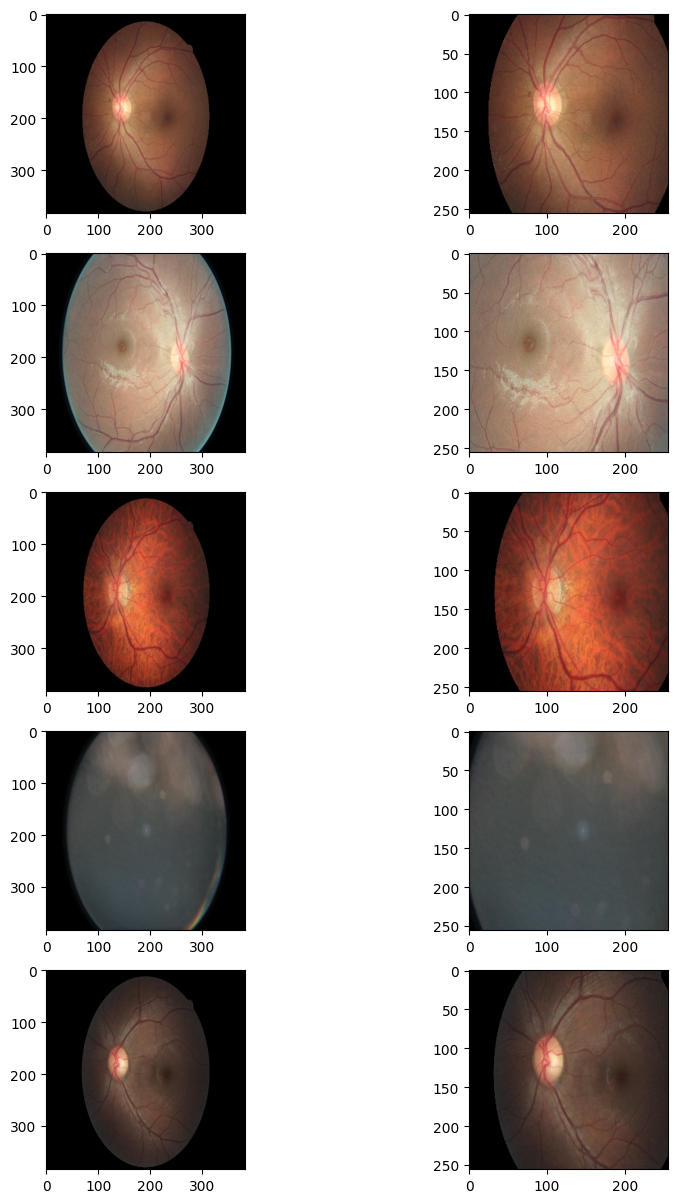

In [107]:
k=50
fig,ax=plt.subplots(nrows=5,ncols=2,figsize=(10,15))
for i in range(5):
    ax[i][0].imshow(train_img[k]/255.)
    ax[i][1].imshow(dataset[k]/255.)
    k+=1

In [ ]:
dataset=np.delete(dataset,left_out,axis=0)
new_label=np.delete(train_label,left_out,axis=0)
print(dataset.shape)
print(new_label.shape)

In [16]:
np.save('cropped_optic',(np.delete(dataset,left_out,axis=0)))
np.save('new_label',(np.delete(train_label,left_out,axis=0)))